# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 2

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [26]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [27]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [39]:
epoch = 5
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 0.010
[2] loss: 0.013
[3] loss: 0.008
[4] loss: 0.007
[5] loss: 0.013


In [34]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 2])

In [40]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

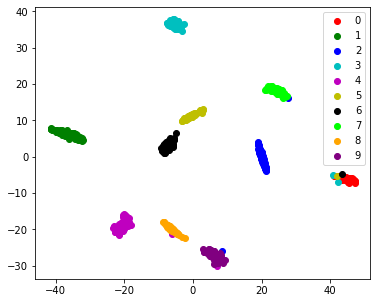

In [41]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

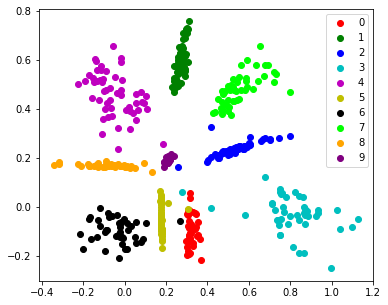

In [42]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

In [43]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [44]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [45]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.3189,  0.2799,  0.5271,  0.7930, -0.0422,  0.1766, -0.0672,  0.5453,
         -0.0445,  0.2119],
        [-0.0772,  0.6448,  0.2344,  0.0060,  0.5148, -0.0327, -0.0631,  0.5045,
          0.1665,  0.1952]])

In [46]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [47]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [48]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [49]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_9.cfg')

['./config/sswae_dev2_1_9.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
#mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 2
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.319705e-01  D: 6.909629e-01  D2: 8.001517e-03  D3: 2.582606e-03
test loss: 1.679372e-01  D: 6.767367e-01  D2: -2.993574e-03  D3: 4.837067e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.597621e-01  D: 6.939985e-01  D2: -4.380352e-03  D3: 6.326188e-03
test loss: 1.542761e-01  D: 6.534122e-01  D2: -4.690475e-03  D3: 8.468830e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.457184e-01  D: 6.932409e-01  D2: -4.464889e-03  D3: 6.784480e-03
test loss: 1.370228e-01  D: 6.810580e-01  D2: -5.264921e-03  D3: 5.931677e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.383756e-01  D: 6.949521e-01  D2: -4.546742e-03  D3: 8.215089e-03
test loss: 1.268786e-01  D: 7.052652e-01  D2: -3.615732e-03  D3: 7.966775e-03


[default |INFO|model.py:1280] [05/80]  loss: 1.177810e-01  D: 6.951552e-01  D2: -4.778473e-03  D3: 9.849591e-03
test loss: 1.120952e-01  D: 6.830262e-01  D2: -5.160017e-03  D3: 1.073790e-02


[default |INFO|model.py:1280] [06/80]  loss: 1.145716e-01  D: 6.950682e-01  D2: -4.918590e-03  D3: 1.115538e-02
test loss: 1.052277e-01  D: 6.889381e-01  D2: -5.433722e-03  D3: 1.295932e-02


[default |INFO|model.py:1280] [07/80]  loss: 1.146104e-01  D: 6.955210e-01  D2: -4.739655e-03  D3: 1.435375e-02
test loss: 1.087890e-01  D: 7.044804e-01  D2: -5.692606e-03  D3: 1.524550e-02


[default |INFO|model.py:1280] [08/80]  loss: 1.098049e-01  D: 6.950319e-01  D2: -4.953626e-03  D3: 1.475927e-02
test loss: 9.736687e-02  D: 6.981204e-01  D2: -4.211102e-03  D3: 1.217142e-02


[default |INFO|model.py:1280] [09/80]  loss: 9.918775e-02  D: 6.934446e-01  D2: -5.335371e-03  D3: 1.464433e-02
test loss: 9.343750e-02  D: 6.918525e-01  D2: -4.885912e-03  D3: 1.480949e-02


[default |INFO|model.py:1280] [10/80]  loss: 9.133443e-02  D: 6.933132e-01  D2: -5.228310e-03  D3: 1.461782e-02
test loss: 8.936640e-02  D: 6.880678e-01  D2: -5.552053e-03  D3: 1.492608e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.889500e-02  D: 6.938227e-01  D2: -5.458674e-03  D3: 1.385324e-02
test loss: 8.817132e-02  D: 6.985827e-01  D2: -5.927658e-03  D3: 1.468816e-02


[default |INFO|model.py:1280] [12/80]  loss: 8.678741e-02  D: 6.936225e-01  D2: -5.714982e-03  D3: 1.360767e-02
test loss: 8.436412e-02  D: 6.992307e-01  D2: -6.244364e-03  D3: 1.447540e-02


[default |INFO|model.py:1280] [13/80]  loss: 8.522298e-02  D: 6.939696e-01  D2: -5.719104e-03  D3: 1.339443e-02
test loss: 8.278456e-02  D: 6.904698e-01  D2: -6.094294e-03  D3: 1.268044e-02


[default |INFO|model.py:1280] [14/80]  loss: 8.463173e-02  D: 6.939371e-01  D2: -5.937505e-03  D3: 1.306159e-02
test loss: 8.182758e-02  D: 7.141983e-01  D2: -6.404400e-03  D3: 1.424732e-02


[default |INFO|model.py:1280] [15/80]  loss: 8.278256e-02  D: 6.940475e-01  D2: -6.280541e-03  D3: 1.296176e-02
test loss: 8.477978e-02  D: 7.005481e-01  D2: -5.673265e-03  D3: 1.234809e-02


[default |INFO|model.py:1280] [16/80]  loss: 8.198037e-02  D: 6.933402e-01  D2: -6.191730e-03  D3: 1.263839e-02
test loss: 8.227653e-02  D: 7.015956e-01  D2: -5.555401e-03  D3: 1.258423e-02


[default |INFO|model.py:1280] [17/80]  loss: 8.073695e-02  D: 6.936713e-01  D2: -6.404829e-03  D3: 1.268900e-02
test loss: 8.086626e-02  D: 6.942827e-01  D2: -6.881237e-03  D3: 1.268639e-02


[default |INFO|model.py:1280] [18/80]  loss: 7.988551e-02  D: 6.938696e-01  D2: -6.407857e-03  D3: 1.237689e-02
test loss: 7.752635e-02  D: 6.914140e-01  D2: -6.977530e-03  D3: 1.213288e-02


[default |INFO|model.py:1280] [19/80]  loss: 7.934297e-02  D: 6.934937e-01  D2: -6.502684e-03  D3: 1.235569e-02
test loss: 7.769552e-02  D: 6.852805e-01  D2: -6.863270e-03  D3: 1.312758e-02


[default |INFO|model.py:1280] [20/80]  loss: 7.810986e-02  D: 6.939578e-01  D2: -6.690647e-03  D3: 1.216897e-02
test loss: 7.700322e-02  D: 7.007776e-01  D2: -6.674747e-03  D3: 1.263936e-02


[default |INFO|model.py:1280] [21/80]  loss: 7.829185e-02  D: 6.937686e-01  D2: -6.763689e-03  D3: 1.193153e-02
test loss: 7.989506e-02  D: 6.842289e-01  D2: -6.858578e-03  D3: 1.049581e-02


[default |INFO|model.py:1280] [22/80]  loss: 7.640666e-02  D: 6.929789e-01  D2: -6.998299e-03  D3: 1.202986e-02
test loss: 7.508519e-02  D: 6.975291e-01  D2: -7.373695e-03  D3: 1.229576e-02


[default |INFO|model.py:1280] [23/80]  loss: 7.564334e-02  D: 6.933606e-01  D2: -7.067483e-03  D3: 1.187286e-02
test loss: 7.780953e-02  D: 6.929962e-01  D2: -7.114744e-03  D3: 1.297506e-02


[default |INFO|model.py:1280] [24/80]  loss: 7.526359e-02  D: 6.934272e-01  D2: -7.097637e-03  D3: 1.191935e-02
test loss: 7.739473e-02  D: 7.085353e-01  D2: -7.062416e-03  D3: 1.229129e-02


[default |INFO|model.py:1280] [25/80]  loss: 7.515009e-02  D: 6.936300e-01  D2: -6.986952e-03  D3: 1.172611e-02
test loss: 7.441627e-02  D: 7.002882e-01  D2: -7.007694e-03  D3: 1.189808e-02


[default |INFO|model.py:1280] [26/80]  loss: 7.427135e-02  D: 6.934128e-01  D2: -7.286151e-03  D3: 1.168078e-02
test loss: 7.412888e-02  D: 6.971050e-01  D2: -7.009048e-03  D3: 1.086124e-02


[default |INFO|model.py:1280] [27/80]  loss: 7.343179e-02  D: 6.935110e-01  D2: -7.306528e-03  D3: 1.153091e-02
test loss: 7.317185e-02  D: 6.871736e-01  D2: -6.955280e-03  D3: 1.185983e-02


[default |INFO|model.py:1280] [28/80]  loss: 7.373200e-02  D: 6.935602e-01  D2: -7.402557e-03  D3: 1.157736e-02
test loss: 7.378641e-02  D: 7.007165e-01  D2: -7.353678e-03  D3: 1.298850e-02


[default |INFO|model.py:1280] [29/80]  loss: 7.224159e-02  D: 6.934596e-01  D2: -7.422902e-03  D3: 1.150850e-02
test loss: 7.331081e-02  D: 7.021427e-01  D2: -7.487707e-03  D3: 1.231844e-02


[default |INFO|model.py:1280] [30/80]  loss: 7.241111e-02  D: 6.936085e-01  D2: -7.436047e-03  D3: 1.135873e-02
test loss: 7.288690e-02  D: 7.012888e-01  D2: -7.068233e-03  D3: 1.072267e-02


[default |INFO|model.py:1280] [31/80]  loss: 7.179581e-02  D: 6.932921e-01  D2: -7.596067e-03  D3: 1.136219e-02
test loss: 7.360513e-02  D: 6.886497e-01  D2: -7.790766e-03  D3: 1.050569e-02


[default |INFO|model.py:1280] [32/80]  loss: 7.161652e-02  D: 6.932898e-01  D2: -7.653963e-03  D3: 1.128715e-02
test loss: 7.258339e-02  D: 6.945870e-01  D2: -7.790384e-03  D3: 1.172067e-02


[default |INFO|model.py:1280] [33/80]  loss: 7.126920e-02  D: 6.933769e-01  D2: -7.626952e-03  D3: 1.131075e-02
test loss: 7.224147e-02  D: 6.970031e-01  D2: -8.034840e-03  D3: 1.087211e-02


[default |INFO|model.py:1280] [34/80]  loss: 7.137430e-02  D: 6.934137e-01  D2: -7.835239e-03  D3: 1.116060e-02
test loss: 7.094571e-02  D: 6.923044e-01  D2: -8.030615e-03  D3: 1.043635e-02


[default |INFO|model.py:1280] [35/80]  loss: 7.042425e-02  D: 6.933777e-01  D2: -7.784216e-03  D3: 1.122418e-02
test loss: 7.136319e-02  D: 6.938951e-01  D2: -7.564650e-03  D3: 1.094738e-02


[default |INFO|model.py:1280] [36/80]  loss: 7.014617e-02  D: 6.932202e-01  D2: -7.925301e-03  D3: 1.111254e-02
test loss: 7.211004e-02  D: 6.926294e-01  D2: -7.706671e-03  D3: 1.059023e-02


[default |INFO|model.py:1280] [37/80]  loss: 7.003967e-02  D: 6.932625e-01  D2: -7.844745e-03  D3: 1.106858e-02
test loss: 7.179719e-02  D: 7.022113e-01  D2: -8.213263e-03  D3: 1.189469e-02


[default |INFO|model.py:1280] [38/80]  loss: 7.025903e-02  D: 6.935285e-01  D2: -7.967712e-03  D3: 1.100755e-02
test loss: 7.181440e-02  D: 6.909809e-01  D2: -7.779799e-03  D3: 1.159909e-02


[default |INFO|model.py:1280] [39/80]  loss: 6.950000e-02  D: 6.934256e-01  D2: -8.062255e-03  D3: 1.102776e-02
test loss: 7.102961e-02  D: 7.001679e-01  D2: -8.349457e-03  D3: 1.194921e-02


[default |INFO|model.py:1280] [40/80]  loss: 6.906174e-02  D: 6.932357e-01  D2: -8.118634e-03  D3: 1.101533e-02
test loss: 7.044207e-02  D: 6.986904e-01  D2: -8.097229e-03  D3: 1.114488e-02


[default |INFO|model.py:1280] [41/80]  loss: 6.905291e-02  D: 6.933008e-01  D2: -8.153617e-03  D3: 1.076318e-02
test loss: 7.033586e-02  D: 6.883913e-01  D2: -7.220144e-03  D3: 9.880239e-03


[default |INFO|model.py:1280] [42/80]  loss: 6.861950e-02  D: 6.933413e-01  D2: -8.120763e-03  D3: 1.092079e-02
test loss: 7.025411e-02  D: 7.042386e-01  D2: -7.959785e-03  D3: 1.120483e-02


[default |INFO|model.py:1280] [43/80]  loss: 6.874925e-02  D: 6.930632e-01  D2: -8.235871e-03  D3: 1.079829e-02
test loss: 7.020473e-02  D: 6.951151e-01  D2: -8.327131e-03  D3: 1.032113e-02


[default |INFO|model.py:1280] [44/80]  loss: 6.826270e-02  D: 6.932785e-01  D2: -8.238138e-03  D3: 1.077416e-02
test loss: 6.908468e-02  D: 6.954162e-01  D2: -8.524952e-03  D3: 1.070852e-02


[default |INFO|model.py:1280] [45/80]  loss: 6.809679e-02  D: 6.932206e-01  D2: -8.277817e-03  D3: 1.091679e-02
test loss: 7.044123e-02  D: 6.956254e-01  D2: -8.375578e-03  D3: 1.063572e-02


[default |INFO|model.py:1280] [46/80]  loss: 6.780912e-02  D: 6.932729e-01  D2: -8.308846e-03  D3: 1.080384e-02
test loss: 7.034060e-02  D: 6.916716e-01  D2: -8.560562e-03  D3: 1.126100e-02


[default |INFO|model.py:1280] [47/80]  loss: 6.748024e-02  D: 6.932762e-01  D2: -8.452779e-03  D3: 1.072715e-02
test loss: 7.014618e-02  D: 6.910159e-01  D2: -8.349762e-03  D3: 1.038964e-02


[default |INFO|model.py:1280] [48/80]  loss: 6.722901e-02  D: 6.932347e-01  D2: -8.431209e-03  D3: 1.074296e-02
test loss: 6.930069e-02  D: 6.908912e-01  D2: -8.407555e-03  D3: 9.941837e-03


[default |INFO|model.py:1280] [49/80]  loss: 6.750969e-02  D: 6.932274e-01  D2: -8.382095e-03  D3: 1.073843e-02
test loss: 6.934988e-02  D: 6.958845e-01  D2: -8.686171e-03  D3: 1.117027e-02


[default |INFO|model.py:1280] [50/80]  loss: 6.667550e-02  D: 6.931786e-01  D2: -8.571423e-03  D3: 1.068736e-02
test loss: 6.892758e-02  D: 6.927465e-01  D2: -8.478699e-03  D3: 1.041991e-02


[default |INFO|model.py:1280] [51/80]  loss: 6.711298e-02  D: 6.933529e-01  D2: -8.442365e-03  D3: 1.062016e-02
test loss: 6.905952e-02  D: 6.907327e-01  D2: -8.455935e-03  D3: 1.066220e-02


[default |INFO|model.py:1280] [52/80]  loss: 6.712903e-02  D: 6.932518e-01  D2: -8.595181e-03  D3: 1.059451e-02
test loss: 6.830945e-02  D: 6.928618e-01  D2: -8.484316e-03  D3: 9.885920e-03


[default |INFO|model.py:1280] [53/80]  loss: 6.699766e-02  D: 6.932424e-01  D2: -8.595344e-03  D3: 1.052713e-02
test loss: 6.966870e-02  D: 6.936689e-01  D2: -8.791227e-03  D3: 1.120317e-02


[default |INFO|model.py:1280] [54/80]  loss: 6.688150e-02  D: 6.933162e-01  D2: -8.703246e-03  D3: 1.066969e-02
test loss: 6.940428e-02  D: 6.908087e-01  D2: -8.358459e-03  D3: 1.038400e-02


[default |INFO|model.py:1280] [55/80]  loss: 6.667228e-02  D: 6.933968e-01  D2: -8.679069e-03  D3: 1.051690e-02
test loss: 7.005911e-02  D: 6.959518e-01  D2: -8.471050e-03  D3: 9.724343e-03


[default |INFO|model.py:1280] [56/80]  loss: 6.647687e-02  D: 6.932124e-01  D2: -8.603614e-03  D3: 1.041084e-02
test loss: 6.834399e-02  D: 6.954753e-01  D2: -8.648958e-03  D3: 1.098216e-02


[default |INFO|model.py:1280] [57/80]  loss: 6.593939e-02  D: 6.932768e-01  D2: -8.640847e-03  D3: 1.049747e-02
test loss: 6.929182e-02  D: 6.939815e-01  D2: -8.512011e-03  D3: 1.011242e-02


[default |INFO|model.py:1280] [58/80]  loss: 6.563085e-02  D: 6.932106e-01  D2: -8.689421e-03  D3: 1.051718e-02
test loss: 6.834259e-02  D: 6.933638e-01  D2: -8.584242e-03  D3: 1.010131e-02


[default |INFO|model.py:1280] [59/80]  loss: 6.583784e-02  D: 6.931882e-01  D2: -8.699938e-03  D3: 1.066569e-02
test loss: 6.791031e-02  D: 6.934305e-01  D2: -8.734722e-03  D3: 1.066740e-02


[default |INFO|model.py:1280] [60/80]  loss: 6.617308e-02  D: 6.932804e-01  D2: -8.773011e-03  D3: 1.034565e-02
test loss: 6.944341e-02  D: 6.921522e-01  D2: -8.712044e-03  D3: 1.054269e-02


[default |INFO|model.py:1280] [61/80]  loss: 6.576524e-02  D: 6.932151e-01  D2: -8.754818e-03  D3: 1.051476e-02
test loss: 6.814211e-02  D: 6.915953e-01  D2: -8.907394e-03  D3: 1.066299e-02


[default |INFO|model.py:1280] [62/80]  loss: 6.516339e-02  D: 6.931810e-01  D2: -8.750874e-03  D3: 1.042161e-02
test loss: 6.746144e-02  D: 6.923912e-01  D2: -8.779564e-03  D3: 1.019745e-02


[default |INFO|model.py:1280] [63/80]  loss: 6.512904e-02  D: 6.932689e-01  D2: -8.767536e-03  D3: 1.044377e-02
test loss: 6.819109e-02  D: 6.924214e-01  D2: -8.694067e-03  D3: 9.598152e-03


[default |INFO|model.py:1280] [64/80]  loss: 6.555459e-02  D: 6.934928e-01  D2: -8.820244e-03  D3: 1.027811e-02
test loss: 6.919615e-02  D: 6.918480e-01  D2: -8.902044e-03  D3: 1.234911e-02


[default |INFO|model.py:1280] [65/80]  loss: 6.513212e-02  D: 6.932093e-01  D2: -8.761582e-03  D3: 1.031420e-02
test loss: 6.777919e-02  D: 6.889343e-01  D2: -9.047003e-03  D3: 1.011390e-02


[default |INFO|model.py:1280] [66/80]  loss: 6.486765e-02  D: 6.932810e-01  D2: -8.840763e-03  D3: 1.032899e-02
test loss: 6.699583e-02  D: 6.942226e-01  D2: -8.734303e-03  D3: 1.008699e-02


[default |INFO|model.py:1280] [67/80]  loss: 6.466837e-02  D: 6.932060e-01  D2: -8.786120e-03  D3: 1.033980e-02
test loss: 6.836685e-02  D: 6.895272e-01  D2: -8.801603e-03  D3: 1.050756e-02


[default |INFO|model.py:1280] [68/80]  loss: 6.445316e-02  D: 6.932378e-01  D2: -8.806637e-03  D3: 1.031583e-02
test loss: 6.864645e-02  D: 6.928592e-01  D2: -8.945827e-03  D3: 9.769977e-03


[default |INFO|model.py:1280] [69/80]  loss: 6.454047e-02  D: 6.932145e-01  D2: -8.858174e-03  D3: 1.025648e-02
test loss: 6.938913e-02  D: 6.951832e-01  D2: -9.120598e-03  D3: 9.025188e-03


[default |INFO|model.py:1280] [70/80]  loss: 6.447343e-02  D: 6.931644e-01  D2: -8.879094e-03  D3: 1.028708e-02
test loss: 6.743876e-02  D: 7.032219e-01  D2: -9.070597e-03  D3: 1.052872e-02


[default |INFO|model.py:1280] [71/80]  loss: 6.457169e-02  D: 6.933519e-01  D2: -8.876573e-03  D3: 1.028836e-02
test loss: 6.662953e-02  D: 6.932868e-01  D2: -8.899717e-03  D3: 1.026345e-02


[default |INFO|model.py:1280] [72/80]  loss: 6.449558e-02  D: 6.930895e-01  D2: -8.958282e-03  D3: 1.011244e-02
test loss: 6.717228e-02  D: 6.956552e-01  D2: -8.643198e-03  D3: 1.065799e-02


[default |INFO|model.py:1280] [73/80]  loss: 6.394747e-02  D: 6.938674e-01  D2: -8.914723e-03  D3: 1.011643e-02
test loss: 6.717412e-02  D: 6.916060e-01  D2: -9.092045e-03  D3: 9.805756e-03


[default |INFO|model.py:1280] [74/80]  loss: 6.373474e-02  D: 6.932606e-01  D2: -8.863368e-03  D3: 1.021697e-02
test loss: 6.658993e-02  D: 6.860304e-01  D2: -9.019604e-03  D3: 1.086515e-02


[default |INFO|model.py:1280] [75/80]  loss: 6.392600e-02  D: 6.933223e-01  D2: -8.916127e-03  D3: 1.016724e-02
test loss: 6.813589e-02  D: 6.978532e-01  D2: -8.984823e-03  D3: 9.494587e-03


[default |INFO|model.py:1280] [76/80]  loss: 6.435938e-02  D: 6.930551e-01  D2: -8.907820e-03  D3: 1.017115e-02
test loss: 6.791816e-02  D: 6.889568e-01  D2: -8.925762e-03  D3: 9.524286e-03


[default |INFO|model.py:1280] [77/80]  loss: 6.383287e-02  D: 6.931823e-01  D2: -8.951399e-03  D3: 1.010582e-02
test loss: 6.645575e-02  D: 6.933135e-01  D2: -9.105473e-03  D3: 1.047376e-02


[default |INFO|model.py:1280] [78/80]  loss: 6.384583e-02  D: 6.932604e-01  D2: -8.923219e-03  D3: 1.016502e-02
test loss: 6.646501e-02  D: 6.921208e-01  D2: -8.662605e-03  D3: 9.588812e-03


[default |INFO|model.py:1280] [79/80]  loss: 6.326071e-02  D: 6.931327e-01  D2: -8.932168e-03  D3: 1.012199e-02
test loss: 6.775841e-02  D: 6.951829e-01  D2: -8.781881e-03  D3: 9.581360e-03


[default |INFO|model.py:1280] [80/80]  loss: 6.338277e-02  D: 6.935530e-01  D2: -8.965495e-03  D3: 1.007853e-02
test loss: 6.646305e-02  D: 6.937080e-01  D2: -8.980894e-03  D3: 1.003689e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3125.327s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

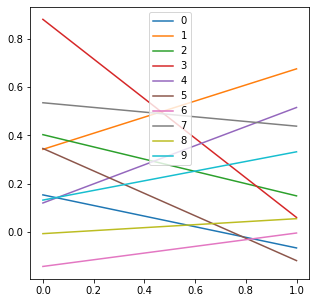

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

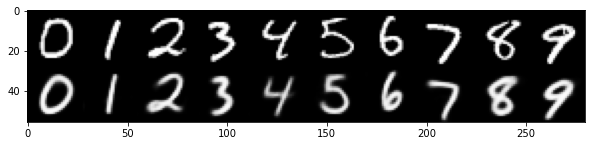

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

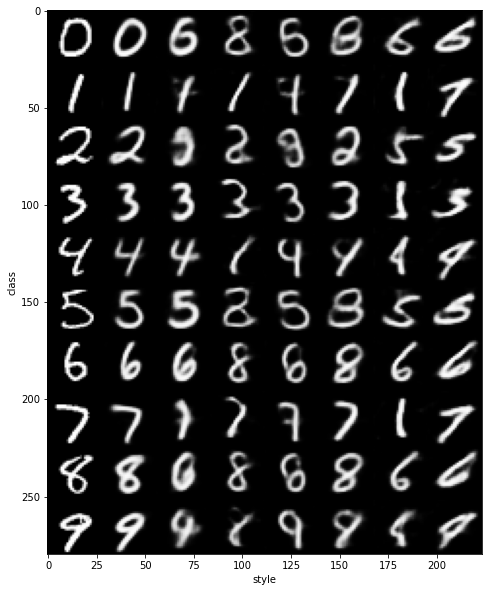

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

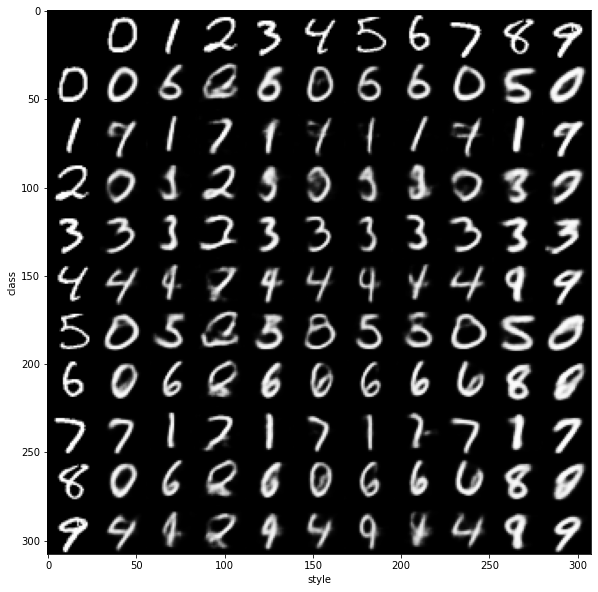

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()